In [1]:
import torch
import torch.nn as nn
from skimage.io import imread
from torch.utils import data
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib
import torchvision.transforms.functional as fn
from torchvision.io import read_image
from torchvision import transforms
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import cv2 as cv

In [3]:
transform = transforms.Grayscale()
from tqdm import tqdm


class SegmentationDataSet2(data.Dataset):
    """Image segmentation dataset with caching and pretransforms."""
    def __init__(self,
                 inputs: list,
                 targets: list,
                 transform=None,
                 use_cache=False,
                 pre_transform=None,
                 ):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long
        self.use_cache = use_cache
        self.pre_transform = pre_transform

        if self.use_cache:
            self.cached_data = []

            progressbar = tqdm(range(len(self.inputs)), desc='Caching')
            for i, img_name, tar_name in zip(progressbar, self.inputs, self.targets):
                img, tar = imread(str(img_name)), imread(str(tar_name))
                if self.pre_transform is not None:
                    img, tar = self.pre_transform(img, tar)

                self.cached_data.append((img, tar))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,
                    index: int):
        if self.use_cache:
            x, y = self.cached_data[index]
        else:
            # Select the sample
            input_ID = self.inputs[index]
            target_ID = self.targets[index]

            # Load input and target
            x, y = read_image(input_ID), read_image(target_ID)
            x, y = x.type(self.inputs_dtype), y.type(self.targets_dtype)
            x = (x - torch.min(x)) / (torch.max(x)-torch.min(x))
            y = transform(y)
            x,y = fn.resize(x,size=[512,512]),fn.resize(y,size=[512,512])
            y[y>0]=1
            y.squeeze()

        # Preprocessing
        if self.transform is not None:
            x, y = self.transform(x, y)

        
        

        return x, y

In [4]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 984.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 3.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ebaedc5a8363048417c62a62b717a0a65e041cd7fb220a0c6333010498a8827c
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=6b442da24f997444f6b508d0cade5a5f9f8f5d0ff58bca6aa00b422bf30d1335
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [5]:
##Getting the firectories of all the images


inputs = []
dir1 =  '../input/contrail-dataset-new/FinalData/FalseColor'
for root, dirs, files in os.walk(dir1):
    inputs.extend(files)
inputs = sorted(inputs)

rgbs = []
dir3 = '../input/contrail-dataset-new/FinalData/RGB'
for root, dirs, files in os.walk(dir3):
    rgbs.extend(files)
rgbs = sorted(rgbs)
# read annotations
target = []
dir2 = '../input/contrail-dataset-new/FinalData/Contrail'
for root, dirs, files in os.walk(dir2):
    target.extend(files)
target = sorted(target)

r_g_b = []
inp = []
tar = []
for x in inputs:
    inp.append('../input/contrail-dataset-new/FinalData/FalseColor/'+x)
for x in target:
    tar.append('../input/contrail-dataset-new/FinalData/Contrail/'+x)
for x in rgbs:
    r_g_b.append('../input/contrail-dataset-new/FinalData/RGB'+x)
# inputs = inp
# target = tar


In [6]:
##Getting the directories of images which contain one or more than one contrail

input_true = []
target_true = []
rgb_true = []
for count, value in enumerate(tar):
    y = read_image(value)
    y = transform(y)
    y[y>0]=1 
    if(len(y.unique())>1):
        input_true.append(inp[count])
        target_true.append(tar[count])
        rgb_true.append(r_g_b[count])
    if(count%100==0):
        print(count)
          

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200


In [7]:

##Importing tensorboard if needed
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('dlv3except')


##Random seed value is fixed so that our train and valid datset do not change
random_seed = 60



# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    input_true,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    target_true,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

rgb_train, rgb_valid = train_test_split(
    rgb_true,
    random_state=random_seed,
    train_size = train_size,
    shuffle=True)
# dataset training
dataset_train = SegmentationDataSet2(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=None)

# dataset validation
dataset_valid = SegmentationDataSet2(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=None)

##Creating a datset for rgb images for evaluation
dataset_rgb =  SegmentationDataSet2(inputs=rgb_valid,
                                    targets=targets_valid,
                                    transform=None)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=1,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=1,
                                   shuffle=False)

In [8]:
##Trying out the data loaded
batch = dataset_train[114]
x, y = batch

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')
print(f'y = min: {y.min()}; max: {y.max()}')
#Getting the next batch::  x, y = next(iter(dataloader_training))

x = shape: torch.Size([3, 512, 512]); type: torch.float32
x = min: 0.0; max: 1.0
y = shape: torch.Size([1, 512, 512]); class: tensor([0, 1]); type: torch.int64
y = min: 0; max: 1


In [9]:
!pip install albumentations
import numpy as np
import albumentations as album
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
!pip install --upgrade certifi
import re
from segmentation_models_pytorch.utils import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 1.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: certifi
    Found existing installation: certifi 2022.6.15.2
    Uninstalling certifi-2022.6.15.2:
      Successfully uninstalled certifi-2022.6.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
google-api-core 1.33.0 requires protobuf<4.0.0dev,>=3.20.1, but you have protobuf 3.19.4 which is incompatible.
gcsfs 2022.5.0 requires fsspec==2022.5.0, but you have fsspec 2022.8.2 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobu

In [11]:
# # Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#load best saved models from previouscheckpoint 

model1 = torch.load('../input/contrail-segment-models/Unet_Xception.pth', map_location=DEVICE)
print('Loaded model 1 from this run.')
model2 = torch.load('../input/contrail-segment-models/PSP Net with Resnext101.pth', map_location=DEVICE)
print('Loaded model 2 from this run.')
model3 = torch.load('../input/contrail-segment-models/best_modelv3plus resnext.pth', map_location=DEVICE)
print('Loaded model 3 from this run.')
model4 = torch.load('../input/contrail-segment-models/dlv3resnext.pth', map_location=DEVICE)
print('Loaded model 4 from this run.')

Loaded model 1 from this run.
Loaded model 2 from this run.
Loaded model 3 from this run.
Loaded model 4 from this run.


In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
from torchmetrics import JaccardIndex
# iou = JaccardIndex(num_classes=1,average=None).to(device)
iou = smp.utils.metrics.IoU(threshold=0.5)
class Trainer:
    def __init__(self,
                 model1: torch.nn.Module,
                 model2: torch.nn.Module,
                 model3: torch.nn.Module,
                 model4: torch.nn.Module,
                 mode,
                 device: torch.device,
                 training_DataLoader: torch.utils.data.Dataset=None,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model1 = model1
        self.model2= model2
        self.model3 = model3
        self.model4 = model4
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        self.MiouT = []
        self.MiouV = []
        self.mode = mode

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            if self.training_DataLoader is not None:
                self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()
        return self.MiouV , self.MiouT

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model1.eval()
        self.model2.eval()
        self.model3.eval()
        self.model4.eval()# evaluation mode
        miou_list = []
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            inpt, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            del(x,y)
            with torch.no_grad():
                out1 = self.model1(inpt)
                out2 = self.model2(inpt)
                out3 = self.model3(inpt)
                out4 = self.model4(inpt)
                out1 = out1.squeeze()
                out2 = out2.squeeze()
                out3 = out3.squeeze()
                out4 = out4.squeeze()
                if self.mode == torch.mode:
                    out1[out1>=0.5]=1
                    out1[out1<1]=0
                    out2[out2>=0.5]=1
                    out2[out2<1]=0
                    out3[out3>=0.5]=1
                    out3[out3<1]=0
                    out4[out4>=0.5]=1
                    out4[out4<1]=0
                    out = torch.stack((out1,out2,out3,out4))
                    out = self.mode(out,dim=0)
                else:
                    out = torch.stack((out1,out2,out3,out4))
                    out = self.mode(out,dim=0)
                out=out.values
                out = out.reshape((1,1,512,512))
                miou = iou(out,target)
                miou = miou.item()
                miou_list.append(miou)
                del(out)
                batch_iter.set_description(f'training: Miou:{miou}')
        self.MiouT.append(np.mean(miou_list))
        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model1.eval()
        self.model2.eval()
        self.model3.eval()
        self.model4.eval()# evaluation mode
        miou_listV = []
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            inpt, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            del(x,y)
            with torch.no_grad():
                out1 = self.model1(inpt)
                out2 = self.model2(inpt)
                out3 = self.model3(inpt)
                out4 = self.model4(inpt)
                out1 = out1.squeeze()
                out2 = out2.squeeze()
                out3 = out3.squeeze()
                out4 = out4.squeeze()
                if self.mode == torch.mode:
                    out1[out1>=0.5]=1
                    out1[out1<1]=0
                    out2[out2>=0.5]=1
                    out2[out2<1]=0
                    out3[out3>=0.5]=1
                    out3[out3<1]=0
                    out4[out4>=0.5]=1
                    out4[out4<1]=0
                    out = torch.stack((out1,out2,out3,out4))
                    out = self.mode(out,dim=0)
                else:
                    out = torch.stack((out1,out2,out3,out4))
                    out = self.mode(out,dim=0)
                out=out.values
                out = out.reshape((1,1,512,512))
                miou = iou(out,target)
                miou = miou.item()
                miou_listV.append(miou)
                del(out)
                batch_iter.set_description(f'Validation: Miou:{miou}')
        self.MiouV.append(np.mean(miou_listV))
        batch_iter.close()

In [15]:
trainer = Trainer(model1=model1,
                  model2=model2,
                  model3=model3,
                  model4=model4,
                  mode=torch.mode,##or torch.mean()##or torch.max()
                  device=device,
                #  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  epochs=1,
                  epoch=0,
                  notebook=True)
valid_iou, train_iou= trainer.run_trainer()

Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/435 [00:00<?, ?it/s]

In [16]:
valid_iou

[0.36158488778250814]

In [17]:
train_iou

[]

In [35]:
index = 50
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
        image1 = np.asarray(image)
#         name = '/notebooks/ImagesFinal/'+name
#         name = name + str(index) + '.png'
#         plt.imsave(name,image1)
    plt.show()


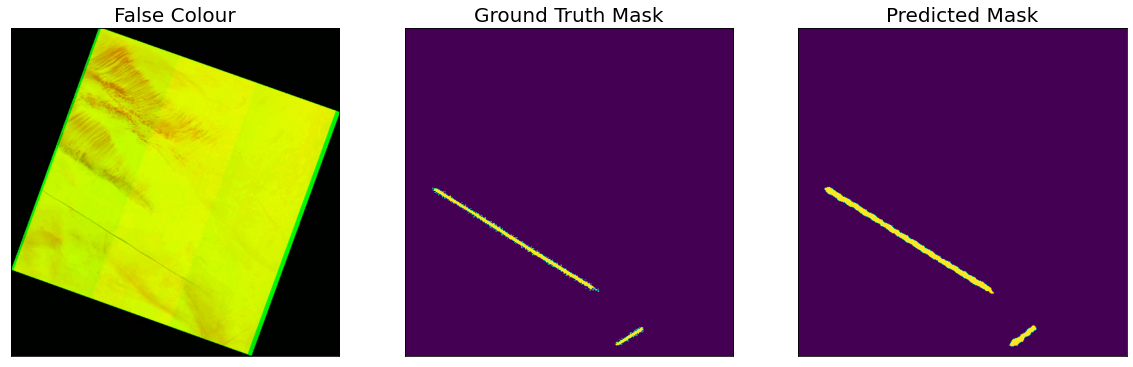

In [36]:
image, gt_mask = dataset_valid[index]
gt_mask = gt_mask.squeeze()
image1=np.asarray(image)
x_tensor = torch.from_numpy(image1).to(DEVICE).unsqueeze(0)
x_tensor.shape
pr_mask = model4.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

gt_mask_final=gt_mask.reshape(512,512)
#y[1]
image_final=image.permute(1, 2, 0)
pr_mask_final=pr_mask.reshape(512,512)
visualize(
        False_Colour = image_final,
        ground_truth_mask = gt_mask_final,
        predicted_mask = pr_mask_final
    )

In [ ]:
image, mask = dataset_rgb[index]
mask = mask.squeeze()
image1=np.asarray(image)
mask_final = mask.squeeze()
# image=np.asarray(image)
image_final=image.permute(1, 2, 0)
visualize(
        RGB = image_final,
        ground_truth_mask_check = mask_final,
    )